Basic imports beforehand

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's grab our cleaned data and put it in a pandas DataFrame. We also remove the games that were terminated early because one of the players was cheating, as these games aren't fair and shouldn't be considered in our analysis.

In [41]:
data = pd.read_pickle('./Chess_Data.pickle')
data.drop(data.loc[data['Termination'] == 'Rules infraction'].index, inplace=True)

First thing to visualize is the win % of each type of game.

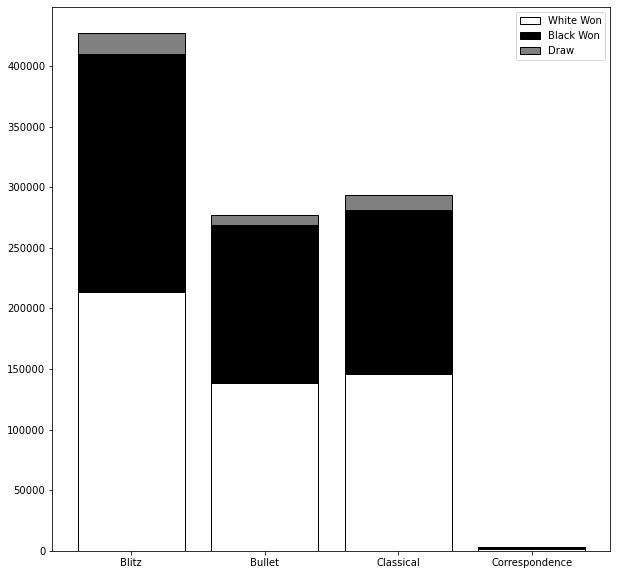

In [70]:
labels = np.unique(data['Game Type'])
whiteWon = [data.loc[(data['Game Type'] == x) & (data['Result'] == '1-0')] for x in labels]
whiteWon = np.array([len(whiteWon[x]) for x in range(len(labels))])
blackWon = [data.loc[(data['Game Type'] == x) & (data['Result'] == '0-1')] for x in labels]
blackWon = np.array([len(blackWon[x]) for x in range(len(labels))])
draw = [data.loc[(data['Game Type'] == x) & (data['Result'] == '1/2-1/2')] for x in labels]
draw = np.array([len(draw[x]) for x in range(len(labels))])
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(labels, whiteWon, label='White Won', color='white', edgecolor='black')
ax.bar(labels, blackWon, bottom=whiteWon, label='Black Won', color='black', edgecolor='black')
ax.bar(labels, draw, bottom=whiteWon + blackWon, label='Draw', color='gray', edgecolor='black')
ax.legend(loc='upper right');

The data on correspondence games is unreadable with this y scale, so let's plot it seperately to get a better idea of what's going on there.

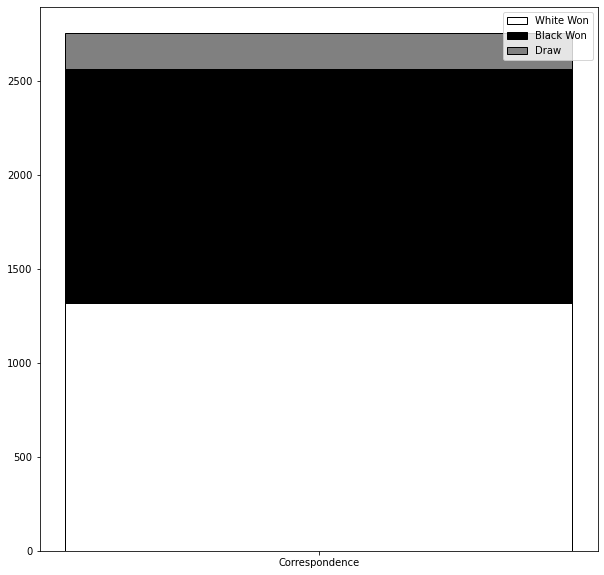

In [71]:

label = np.unique(data['Game Type'])[-1]
whiteWonC = data.loc[(data['Game Type'] == label) & (data['Result'] == '1-0')]
whiteWonC = len(whiteWonC)
blackWonC = data.loc[(data['Game Type'] == label) & (data['Result'] == '0-1')]
blackWonC = len(blackWonC)
drawC = data.loc[(data['Game Type'] == label) & (data['Result'] == '1/2-1/2')]
drawC = len(drawC)
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(label, whiteWonC, label='White Won', color='white', edgecolor='black')
ax.bar(label, blackWonC, bottom=whiteWonC, label='Black Won', color='black', edgecolor='black')
ax.bar(label, drawC, bottom=whiteWonC + blackWonC, label='Draw', color='gray', edgecolor='black')
ax.legend(loc='upper right');